In [1]:
import pickle
import random
import pandas as pd
from construal_shifting.task_modeling.model_fitter import ModelFitter

In [99]:
simulated_participants = pickle.load(open('./data/exp-1-simulated_participants.pkl', 'rb'))

In [103]:
len(next(iter(simulated_participants.values())))

377

In [2]:
results = pickle.load(open('./data/exp-1-simulated_participants-fitting.pkl', 'rb'))

In [86]:
df = pd.DataFrame(results)
df['AIC'] = 2*df['NLL'] + 2*len(df.columns)
gen_param_cols = ['construal_cost_weight_true', 'construal_set_stickiness_true', 'action_random_choice_true']
fit_param_cols = ['fit_construal_cost_weight', 'fit_construal_set_stickiness', 'fit_action_random_choice']
df['gen_params'] = df.apply(
    lambda r : tuple(k.replace('_true', '') for k in gen_param_cols if r[k] != 0), 
    axis=1
)
df['fit_params'] = df.apply(
    lambda r : tuple(k.replace('fit_', '') for k in fit_param_cols if r[k] == True),
    axis=1
)

In [87]:
import numpy as np
best_df = []
for p, gdf in df.groupby(gen_param_cols + fit_param_cols, dropna=False):
    best_run = gdf.iloc[gdf['NLL'].argmin()]
    best_df.append(best_run)
best_df = pd.DataFrame(best_df).reset_index(drop=True)
min_AICs = pd.DataFrame(best_df.groupby(gen_param_cols, dropna=False)['AIC'].min()).rename(columns={'AIC': 'min_AIC'})
best_df = best_df.merge(min_AICs, on=gen_param_cols)
best_df['delta_AIC'] = best_df['AIC'] - best_df['min_AIC']
best_df['fit_both_costs'] = best_df['fit_construal_cost_weight'] & best_df['fit_construal_set_stickiness']

In [90]:
def param_tuple_to_name(param_tuple):
    if set(param_tuple) == set(('action_random_choice', )):
        return 'No costs'
    if set(param_tuple) == set(('construal_cost_weight', 'action_random_choice')):
        return 'Only Complexity'
    if set(param_tuple) == set(('construal_set_stickiness', 'action_random_choice')):
        return 'Only Switch'
    if set(param_tuple) == set(('construal_cost_weight', 'construal_set_stickiness', 'action_random_choice')):
        return 'Both Costs'
confusion_matrix = best_df.groupby(['gen_params', 'fit_params'])['delta_AIC'].mean().astype(int)
confusion_matrix = pd.DataFrame(confusion_matrix).reset_index()
confusion_matrix['gen_params'] = confusion_matrix['gen_params'].apply(param_tuple_to_name)
confusion_matrix['fit_params'] = confusion_matrix['fit_params'].apply(param_tuple_to_name)
confusion_matrix = confusion_matrix.pivot(index='gen_params', columns='fit_params', values='delta_AIC')

model_order = ['No costs', 'Only Complexity', 'Only Switch', 'Both Costs']
confusion_matrix = confusion_matrix[model_order]
confusion_matrix = confusion_matrix.loc[model_order]

Text(0.5, 11.166666666666647, 'Fit Model')

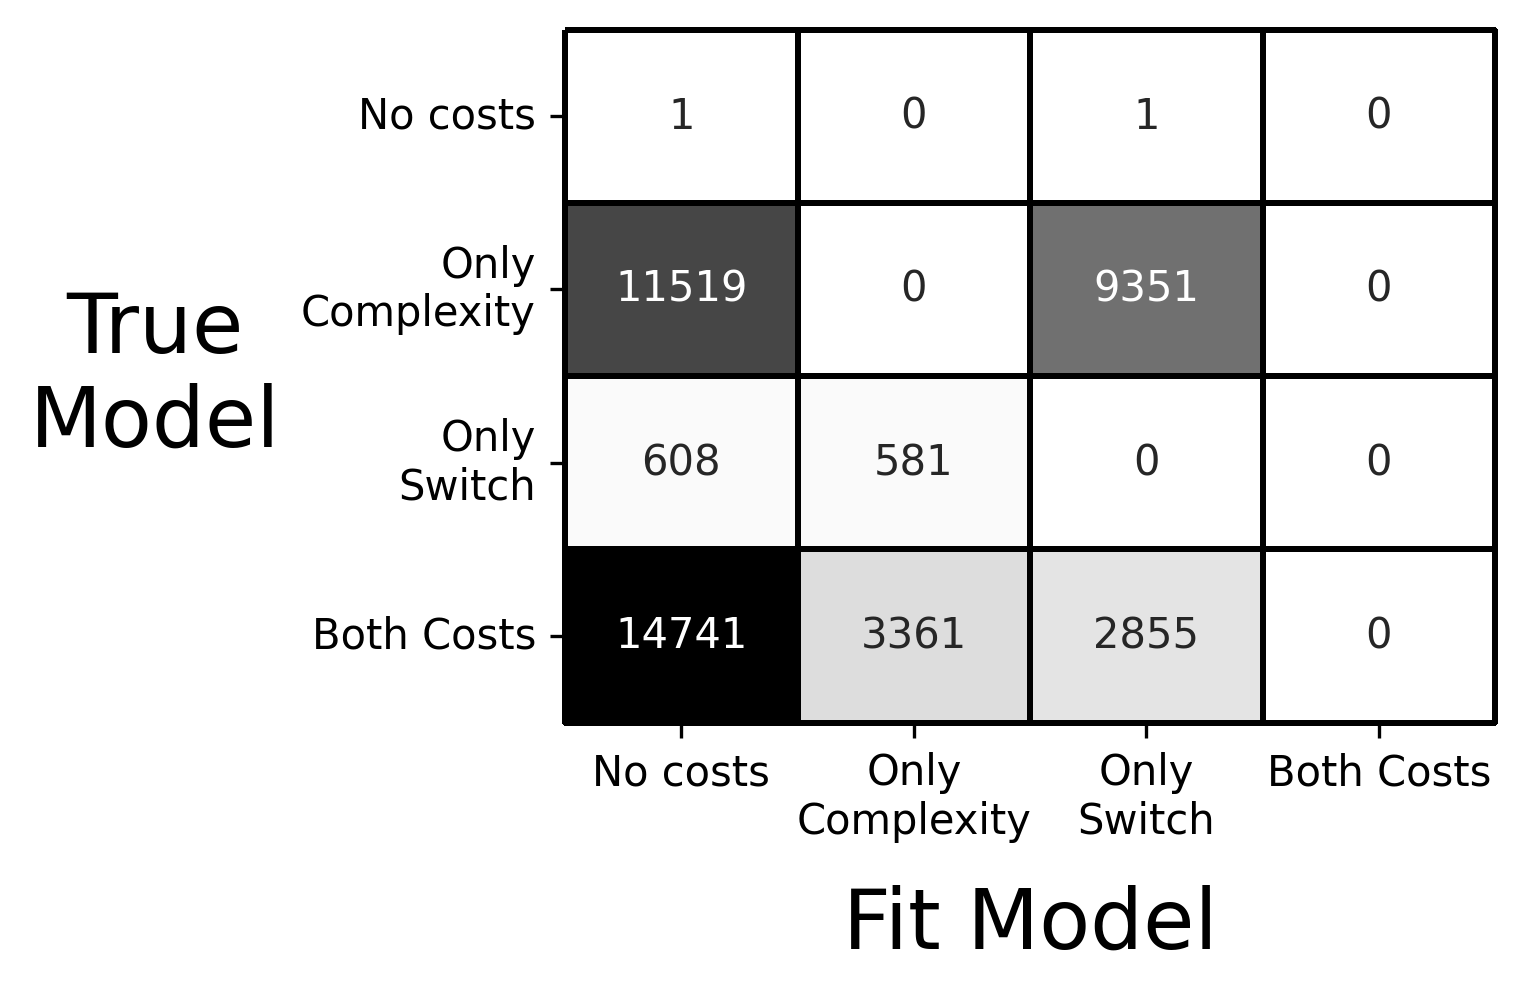

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt='d',
    cmap='Greys',
    cbar=False,
    # square=True,
    linewidths=1,
    linecolor='black',
    clip_on=False,
    ax=ax
)
plt.yticks(rotation=0)
ax.set_ylabel('True\nModel', fontsize=20, rotation=0, labelpad=35, va='center')
ticklabels = [t.get_text() for t in ax.get_yticklabels()]
ticklabels = [t.replace(' ', '\n') if len(t) > 10 else t for t in ticklabels]
ax.set_yticklabels(ticklabels)
ax.set_xticklabels(ticklabels, rotation=0)
ax.set_xlabel('Fit Model', fontsize=20, labelpad=10)

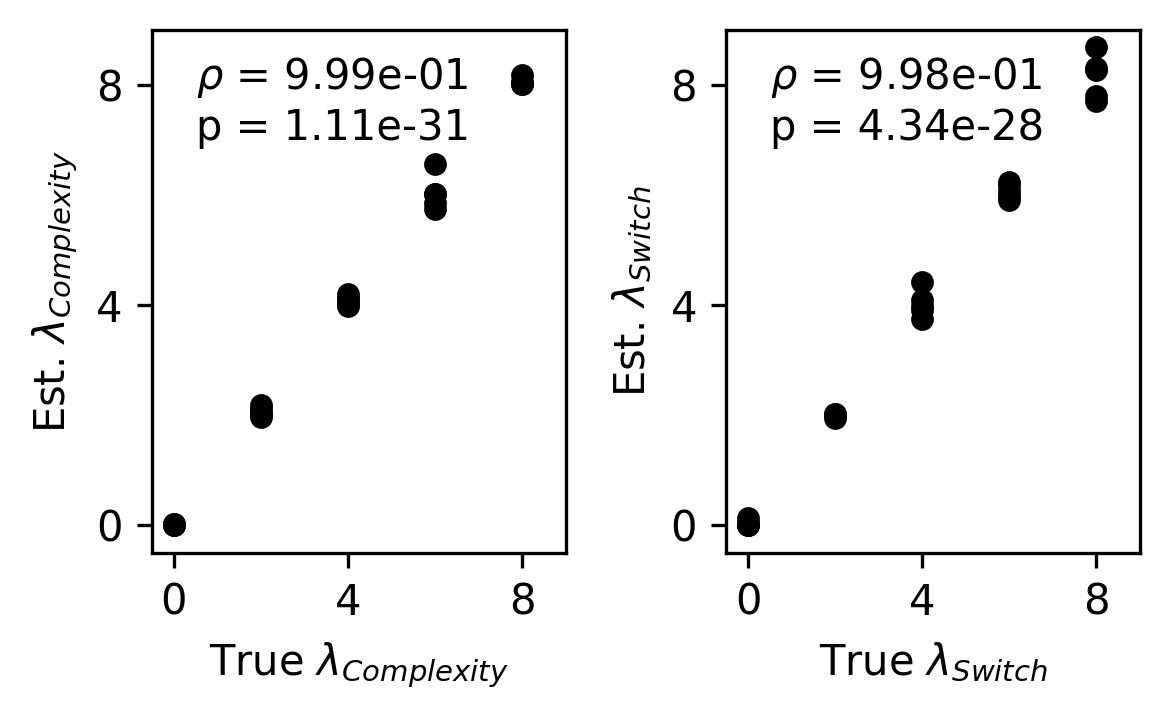

In [98]:
from typing import Sequence
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


fig, axes = plt.subplots(1, 2, figsize=(4, 2.5), dpi=300)
axes : Sequence[plt.Axes]
full_model_fits = best_df[best_df['fit_both_costs']]

full_model_fits.plot(
    kind='scatter',
    x='construal_cost_weight_true',
    y='construal_cost_weight',
    ax=axes[0],
    color='k'
)
coeff, pval = pearsonr(full_model_fits['construal_cost_weight_true'], full_model_fits['construal_cost_weight'])
axes[0].text(.5, 7, f'$\\rho$ = {coeff:.2e}\np = {pval:.2e}')
axes[0].set_xlabel('True $\lambda_{Complexity}$')
axes[0].set_xticks([0, 4, 8])
axes[0].set_yticks([0, 4, 8])
axes[0].set_ylabel('Est. $\lambda_{Complexity}$')
axes[0].set_ylim(-.5, 9)
axes[0].set_xlim(-.5, 9)
full_model_fits.plot(
    kind='scatter',
    x='construal_set_stickiness_true',
    y='construal_set_stickiness',
    ax=axes[1],
    color='k'
)
coeff, pval = pearsonr(full_model_fits['construal_set_stickiness_true'], full_model_fits['construal_set_stickiness'])
axes[1].text(.5, 7, f'$\\rho$ = {coeff:.2e}\np = {pval:.2e}')
axes[1].set_xlabel('True $\lambda_{Switch}$')
axes[1].set_ylabel('Est. $\lambda_{Switch}$')
axes[1].set_xticks([0, 4, 8])
axes[1].set_yticks([0, 4, 8])
axes[1].set_ylim(-.5, 9)
axes[1].set_xlim(-.5, 9)
plt.tight_layout()